In [1]:
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(limma))
suppressPackageStartupMessages(library(beeswarm))
suppressPackageStartupMessages(library(pheatmap))
home = '/nfs/lab/projects/islet_cytok/pipeline/RNAseq/sample'

In [2]:
info = read.table("../data/RNAseq/metadata_edited", header=T, sep="\t")

In [3]:
info = droplevels(subset(info, treatment !="DEX"))

In [4]:
samples = info$name

In [6]:
TPM  = expected_count = matrix(NA, nrow =196520 )
for(samp in samples){
genes = read.table(paste(home, "/", samp, "/rsem/", samp,  ".isoforms.results", sep=""), header=T)
TPM   = cbind(TPM, genes[,"TPM"])

expected_count = cbind(expected_count, genes[,"expected_count"])
}


TPM = TPM[,-1]
expected_count = expected_count[,-1]

 colnames (TPM)=colnames (expected_count) = samples
 rownames (TPM)=rownames (expected_count) = genes[,1]

write.table(TPM, "../pipeline/RNAseq/combined_files/cytok_transcripts.tpm", sep="\t", quote=F)
write.table(expected_count, "../pipeline/RNAseq/combined_files/cytok_transcripts.raw_counts", sep="\t", quote=F)

In [7]:
TPM = FPKM = expected_count = matrix(NA, nrow =57820 )
for(samp in samples){
genes = read.table(paste(home, "/", samp, "/rsem/", samp,  ".genes.results", sep=""), header=T)
TPM   = cbind(TPM, genes[,"TPM"])
FPKM  = cbind(FPKM, genes[,"FPKM"])
expected_count = cbind(expected_count, genes[,"expected_count"])
}

FPKM = FPKM[,-1]
TPM = TPM[,-1]
expected_count = expected_count[,-1]

colnames (FPKM) = colnames (TPM)=colnames (expected_count) = samples
rownames (FPKM) = rownames (TPM)=rownames (expected_count) = genes[,1]

write.table(TPM, "../pipeline/RNAseq/combined_files/cytok_genes.tpm", sep="\t", quote=F)
write.table(FPKM, "../pipeline/RNAseq/combined_files/cytok_genes.fpkm", sep="\t", quote=F)
write.table(expected_count, "../pipeline/RNAseq/combined_files/cytok_genes.raw_counts", sep="\t", quote=F)

### PCA analysis

In [6]:
expected_count = as.matrix(read.table("../pipeline/RNAseq/combined_files/cytok_genes.raw_counts", sep="\t", header=T, row.names=1))
TPM            = read.table("../pipeline/RNAseq/combined_files/cytok_genes.tpm", sep="\t", header=T, row.names=1)

In [7]:
expected_count_all = expected_count
TPM_all = TPM

In [8]:
info = droplevels(subset(info, !(sample %in% c('R310','SAMN11250012'))))
expected_count = subset(expected_count, select=as.character(info$name))
TPM = subset(TPM, select=as.character(info$name))

In [12]:
info$experiment = paste(info$sample, info$treatment, sep="_")

In [15]:
geo_table = expected_count

In [23]:

recode = c('highcyt-TNF-a'='2cyt-hi',  'highcyt+TNF-a'  ='3cyt-hi',
           'lowcyt-TNF-a'='2cyt-lo',  'lowcyt+TNF-a'='3cyt-lo', 
           untreated='untreated')

In [25]:
info$recode = recode[info$treatment]

In [28]:
info$newname = paste(info$sample, info$recode, "24h", sep="_")

In [30]:
colnames(geo_table) = info$newname

In [31]:
write.table(geo_table,"../geo_submission_oct21/processed_files/Bulk_RNASeq_count.matrix.txt", sep="\t", quote=F)

In [12]:
#counts_raw<-subset(expected_count, rowMeans(TPM)>1)   ## filter for low expr. genes
counts_raw<-subset(expected_count, rowMeans(TPM)>0.1)  
dim(counts_raw)

[1] 22175    16

In [13]:
counts = round(counts_raw)

In [14]:
#mat <- vst(counts, blind=FALSE)

In [15]:
mat<- limma::voom(counts_raw)

mat_corrected <- limma::removeBatchEffect(mat, batch= info$sample)

In [17]:
mat_corrected = mat_corrected[order(rowVars(mat_corrected),decreasing=T),]

In [18]:
pca <- prcomp(t(mat_corrected))
pca <- prcomp(t(mat_corrected[1:500,]))
percentVar <- pca$sdev^2 / sum( pca$sdev^2 )
d <- data.frame(PC1=pca$x[,1], PC2=pca$x[,2] , PC3=pca$x[,3], PC4=pca$x[,4], info)

In [ ]:
pdf("../analysis/data_qc/PCA_cytok_500mostvargenes_batchsampl_correct.pdf")
par(pin =c(5,4))

plot(data=d, PC2~PC1,  xlab=(paste0("PC1:" ,round(percentVar[1] * 100),"% variance")),
       ylab=(paste0("PC2:",round(percentVar[2] * 100),"% variance")) , 
       pch= 19,
      col = as.character(d$color),  cex=1.6, las=1, xlim=c(min(d$PC1)-2, max(d$PC1)+2) , 
         ylim=c(min(d$PC2)-2, max(d$PC2)+2) )
grid()
text(d$PC1, d$PC2, str_sub(d$sample, -4,-1), pos=3, cex=0.8 )

legend("bottomright", legend=unique(d$treatment), pch=19, col = as.character(unique(d$color)), bty = "n")

# plot(data=d, PC4~PC3,  xlab=(paste0("PC3:" ,round(percentVar[3] * 100),"% variance")),
#        ylab=(paste0("PC4:",round(percentVar[4] * 100),"% variance")) , 
#        pch= c(19,18,15,4,8,17)[as.numeric(d$sample)],
#       col = as.character(d$color),  cex=1.5, las=1, xlim=c(min(d$PC3)-2, max(d$PC3)+2) , 
#          ylim=c(min(d$PC4)-2, max(d$PC4)+2) )
grid()

dev.off()

In [19]:
write.table(mat,'../pipeline/RNAseq/combined_files/voom_normalized_filtered_gene_expr_cytok.tsv', sep="\t", quote=F)

In [20]:
write.table(mat_corrected, "../pipeline/RNAseq/combined_files/voom_normalized_batc_correct_gene_expr_cytok.tsv", sep="\t", quote=F)

### Find differentially expressed genes

In [21]:
setwd("../analysis/deseq_analysis/")

In [22]:
counts_gid = counts

In [23]:
gene_info = read.table("/nfs/lab/publicdata/gencode_v19/gene_info.tsv", header=T)

rownames(counts) = gene_info$gene_name[match( rownames(counts),gene_info$gene_id)]

In [24]:
info$condition = str_replace_all(info$treatment, "-TNF-a", "2")
info$condition = str_replace_all(info$condition, "\\+TNF-a", "3")
info$condition = str_replace_all(info$condition, "untreated", "untr")

In [25]:
write.table(info, '../../data/RNAseq/metadata_cytok_paper.txt', quote=F, sep="\t")

In [26]:
differential_atac = function (contrast = c("untr", "highcyt3"), samples = info, mat = counts, lab="g") {

#g        = samples[samples$condition %in% contrast, ]
#data     = subset(mat, select = as.character(g$name))

g    = samples    
data = mat
    
### differential accessibility using Deseq2
dds     <- DESeqDataSetFromMatrix(data, g, design= ~ sample + condition)
#dds     <- dds[ rowSums(counts(dds)) > 2, ]
dds     <- DESeq(dds, fitType="parametric")    
res     <- results(dds, contrast=c("condition", contrast[2], contrast[1]))
res     <- as.data.frame(res)

res = res[order(res$pvalue),]
write.table (res, paste( lab, contrast[2], "deseq_results_cytok.tsv", sep="."))

    
   }


In [27]:
#differential_atac(contrast = c("untr", "highcyt3"), samples = info, mat =counts_gid, lab="gid")
#differential_atac(contrast = c("untr", "highcyt3"), samples = info, mat =counts, lab="g")

In [28]:
#differential_atac(contrast = c("untr", "highcyt2"), samples = info, mat =counts_gid, lab="gid")
#differential_atac(contrast = c("untr", "highcyt2"), samples = info, mat =counts, lab="g")

In [29]:
#differential_atac(contrast = c("untr", "lowcyt2"), samples = info, mat =counts_gid, lab="gid")
#differential_atac(contrast = c("untr", "lowcyt2"), samples = info, mat =counts, lab="g")

In [30]:
#differential_atac(contrast = c("untr", "lowcyt3"), samples = info, mat =counts_gid, lab="gid")
#differential_atac(contrast = c("untr", "lowcyt3"), samples = info, mat =counts, lab="g")

In [31]:
differential_atac(contrast = c("highcyt2", "highcyt3"), samples = info, mat =counts_gid, lab="g_idvs2")

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [32]:
tnf = read.table("g_idvs2.highcyt3.deseq_results_cytok.tsv")

In [34]:
tnf = merge(gene_info[,c("gene_id", "gene_name")], tnf, by.x=1, by.y="row.names")

In [36]:
tnf = tnf[order(tnf$pvalue),]

In [40]:
sub = subset(tnf, padj<0.1)

In [41]:
table(sub$log2FoldChange >0)


FALSE  TRUE 
   22    49 

In [42]:
write.table(tnf, 'highcyt3vs2.deseq_results_cytok.txt', sep="\t", quote=F, row.names=F)

In [195]:
pdf("Volcano_plots_fdr10_cytok_supp.pdf")
par(mfrow=c(2,2))

for (f in  c('highcyt3', 'highcyt2', 'lowcyt3', 'lowcyt2')) {
co = as.character(unique(info$color[info$condition==f]))
file =paste( "g", f, "deseq_results_cytok.tsv", sep=".")
res  = read.table(file, row.names=1, header=T)  
plot(-log10(pvalue)~log2FoldChange, res, pch=".", xlim=c(-7,7),
     col = c("black", co)[(res$padj<0.1 )+1] , cex=3 , las=1)
n=10
text(res[1:n,"log2FoldChange"], -log10(res[1:n, "pvalue"]), labels =rownames(res)[1:n], cex=0.6, pos=c(2,4) )
mtext(paste(f, "up=",  sum(res$padj <0.1 & res$log2FoldChange>0, na.rm=T), 
               "down=",  sum(res$padj <0.1 & res$log2FoldChange<0, na.rm=T)))
    
writeLines( na.omit(rownames(res)[res$padj <0.1 & res$log2FoldChange<0]), paste0(f,".down_degs.txt") )      
writeLines( na.omit(rownames(res)[res$padj <0.1 & res$log2FoldChange>0]), paste0(f,".up_degs.txt") )    
    }
dev.off()

png 
  2

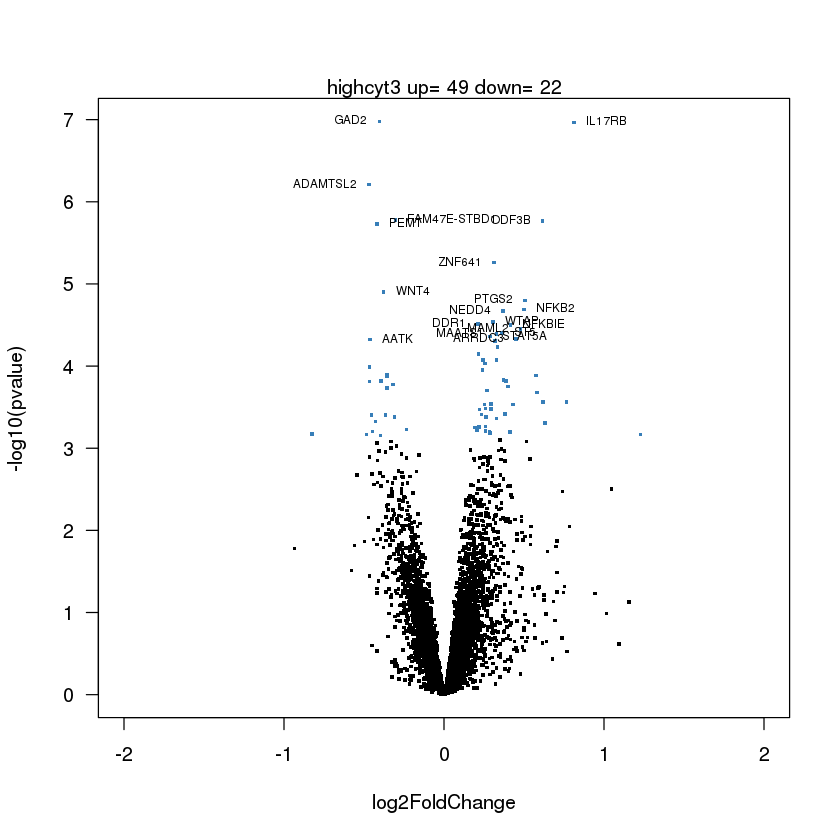

In [293]:
f = 'highcyt3'
file =paste( "gvs2", f, "deseq_results_cytok.tsv", sep=".")
res  = read.table(file, row.names=1, header=T)  
res = res[complete.cases(res),]
plot(-log10(pvalue)~log2FoldChange, res, pch=".", xlim=c(-2,2),
     col = c("black", co)[(res$padj<0.1 )+1] , cex=3 , las=1)
n=20
text(res[1:n,"log2FoldChange"], -log10(res[1:n, "pvalue"]), labels =rownames(res)[1:n], cex=0.6, pos=c(2,4) )
mtext(paste(f, "up=",  sum(res$padj <0.1 & res$log2FoldChange>0, na.rm=T), 
               "down=",  sum(res$padj <0.1 & res$log2FoldChange<0, na.rm=T)))
    
writeLines( na.omit(rownames(res)[res$padj <0.1 & res$log2FoldChange<0]), paste0(f,".down_degs_vs2.txt") )      
writeLines( na.omit(rownames(res)[res$padj <0.1 & res$log2FoldChange>0]), paste0(f,".up_degs_vs2.txt") )    


In [295]:
tnfdiff = na.omit(rownames(res)[res$padj <0.1])

In [296]:
tnfdiff

[1] "GAD2"         "IL17RB"       "ADAMTSL2"     "FAM47E-STBD1" "ODF3B"       
 [6] "PEMT"         "ZNF641"       "WNT4"         "PTGS2"        "NFKB2"       
[11] "NEDD4"        "WTAP"         "DDR1"         "NFKBIE"       "MAML2"       
[16] "ST5"          "MAATS1"       "STAT5A"       "ARRDC3"       "AATK"        
[21] "SLC39A14"     "RFX3"         "SLC11A2"      "CMTM6"        "UBE2Z"       
[26] "ABCB1"        "KCNK16"       "TRAF3"        "KLHL41"       "LYN"         
[31] "MRC1L1"       "INHBA"        "PLA2G4A"      "SLC30A8"      "SLC4A8"      
[36] "CDON"         "SERPINB9"     "VAT1L"        "ARAP1"        "BAMBI"       
[41] "MMP10"        "NFKBIA"       "CHDH"         "RELB"         "MARCKS"      
[46] "NT5DC3"       "PLEKHG3"      "HDGF"         "KIAA1217"     "ECE1"        
[51] "ENTPD3"       "SLC45A3"      "MYO1B"        "GJD2"         "ID4"         
[56] "SCN1B"        "IL6"          "TBC1D9"       "LACC1"        "PNRC2"       
[61] "SEPT5"        "NAB1"         "FRK"          "PTP4A3"       "NAMPT"       
[66] "B4GALT6"      "NCEH1"        "PCK1"         "CXCL10"       "CRYBA2"      
[71] "KCNJ8"

### Compare treatments

In [199]:
suppressPackageStartupMessages(library(matrixStats))
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(RColorBrewer))

In [275]:
l=list()
for (f in  c('highcyt3', 'highcyt2', 'lowcyt3', 'lowcyt2')) {
file =paste( "g", f, "deseq_results_cytok.tsv", sep=".")
res  = read.table(file, row.names=1, header=T)  

l[[f]] = na.omit(rownames(res)[res$padj <0.1])
                 }
                 
u =  data.frame(unique(unlist(l)))
for(n in 1:4){
    u[,n+1] =   u[,1] %in% l[[n]]
}


In [276]:
colnames(u) = c("gene",  c('highcyt3', 'highcyt2', 'lowcyt3', 'lowcyt2'))

v = vennCounts (u[,2:5])


In [204]:
info_uni = info[!duplicated(info$condition),]

In [205]:
annot = data.frame(  Treatment = info$condition, Sample = info$sample)
rownames(annot) = info$name

Sample           = brewer.pal(6, 'Pastel1')
names(Sample)    = unique(info$sample)
Treatment        = as.character(info_uni$color)
names(Treatment) = info_uni$condition
annocol = list(Sample = Sample, Treatment = Treatment)

In [212]:
rownames(mat) = gene_info$gene_name[match( rownames(mat),gene_info$gene_id)]

In [217]:
rownames(mat_corrected) = gene_info$gene_name[match( rownames(mat_corrected),gene_info$gene_id)]

In [281]:
res = res[complete.cases(res),]
selup   = rownames(res)[res$log2FoldChange>0]
seldown = rownames(res)[res$log2FoldChange<0]


In [285]:
commongenes = as.character(u$gene[rowSums(u[,2:5])==4])

In [287]:
coup = commongenes[commongenes %in% selup]
codo = commongenes[commongenes %in% seldown]

In [298]:
sel=unique(c(coup[1:20], codo[1:20], tnfdiff[1:10] ))
pheatmap(mat_corrected[sel,], cluster_rows = T, cluster_cols = T, 
         show_rownames = T,
         col = rev(colorRampPalette(brewer.pal(9, "PuOr"))(50)),
         annotation_col=annot  , annotation_colors = annocol, 
          cellwidth=15, cellheight=8, 
         file ="Heatmap_top_40_DEGs_cytok.pdf",
         scale = 'row', fontsize = 10)


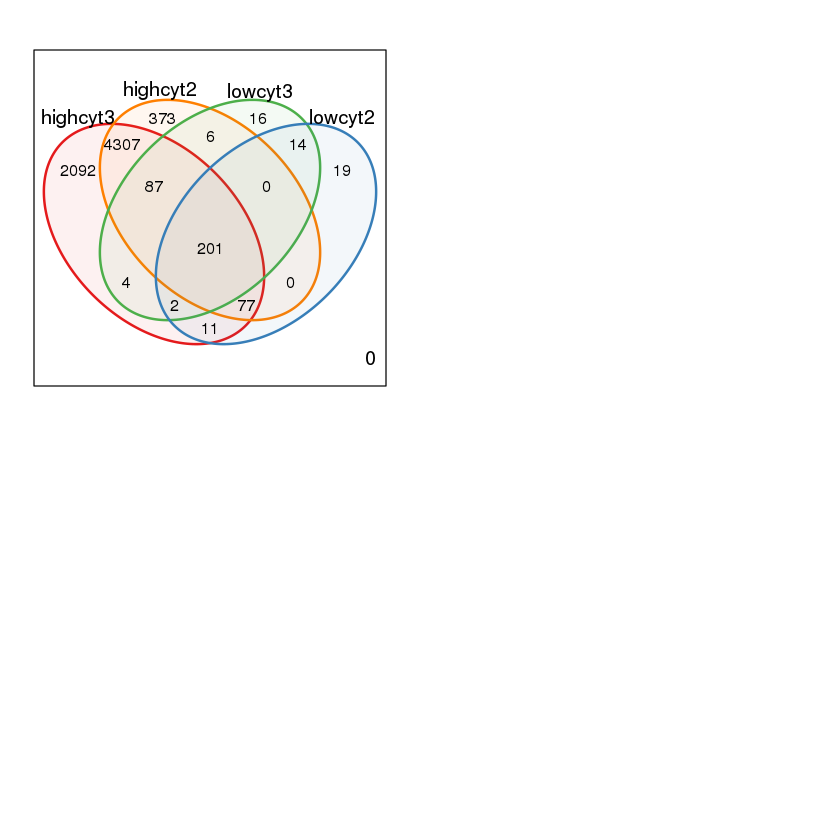

In [209]:
par(mfrow=c(2,2))
vennDiagram(v, lwd=2, bty="o", cex=1.2, circle.col = as.character(info_uni$color)[c(3,2,5,4)])


### barplots

In [311]:
lili = list()
for(x in 3:2){  
for (f in  c('highcyt','lowcyt')) {
file =paste0(f, x, ".up_degs.txt") 
lili[[file]]  = readLines(file)
file =paste0(f, x, ".down_degs.txt") 
lili[[file]]  = readLines(file)   
 }
    }

In [353]:
lapply(lili, length)

$highcyt3.up_degs.txt
[1] 3367

$highcyt3.down_degs.txt
[1] 3414

$lowcyt3.up_degs.txt
[1] 232

$lowcyt3.down_degs.txt
[1] 98

$highcyt2.up_degs.txt
[1] 2543

$highcyt2.down_degs.txt
[1] 2508

$lowcyt2.up_degs.txt
[1] 252

$lowcyt2.down_degs.txt
[1] 72

In [43]:
2543+2508
232+98
252+72

[1] 5051

[1] 330

[1] 324

In [355]:
mm = matrix(lapply(lili, length), ncol = 2, byrow = T)[c(1,3,2,4),]
colnames(mm)= c("Up", "Down")

In [327]:
m = data.frame()

In [328]:
for (x in c(1,2,5,6)){
d = unique(c(lili[[x]], lili[[x+2]]))
df = data.frame(gene = d, hi = d %in% lili[[x]], lo = d %in% lili[[x+2]])
m = rbind(m, table(df[,2:3])[2:4])
    }

In [336]:
colnames(m) = c("hi", 'lo', "both")
rownames(m) = c('3up', '3down', '2up', '2down')

In [374]:
pdf("Compare_DEGs_cytok.pdf")
par(mfrow=c(2,2))
vennDiagram(v, lwd=2, bty="o", cex=1.2, circle.col = as.character(info_uni$color)[c(3,2,5,4)])

barplot(t(m), las=2, legend.text = colnames(m), ylim=c(0,4000), col = c("gray", "gold", "bisque") )
b = barplot(t(mm), las=2, legend.text = colnames(mm), ylim=c(0,7000), col = brewer.pal(9, "PuOr")[c(3,7)] )
text(x = b, y =mm[,1], labels = mm[,1] , pos = 1)
text(x = b, y = as.numeric(mm[,2])+ as.numeric(mm[,1]), labels = mm[,2] , pos = 1)
dev.off()

png 
  2

In [334]:
m

,hi,both,lo
,<int>,<int>,<int>
3up,3150,15,217
3down,3338,22,76
2up,2314,23,229
2down,2461,25,47


In [335]:
table(df[,2:3])

       lo
hi      FALSE TRUE
  FALSE     0   25
  TRUE   2461   47

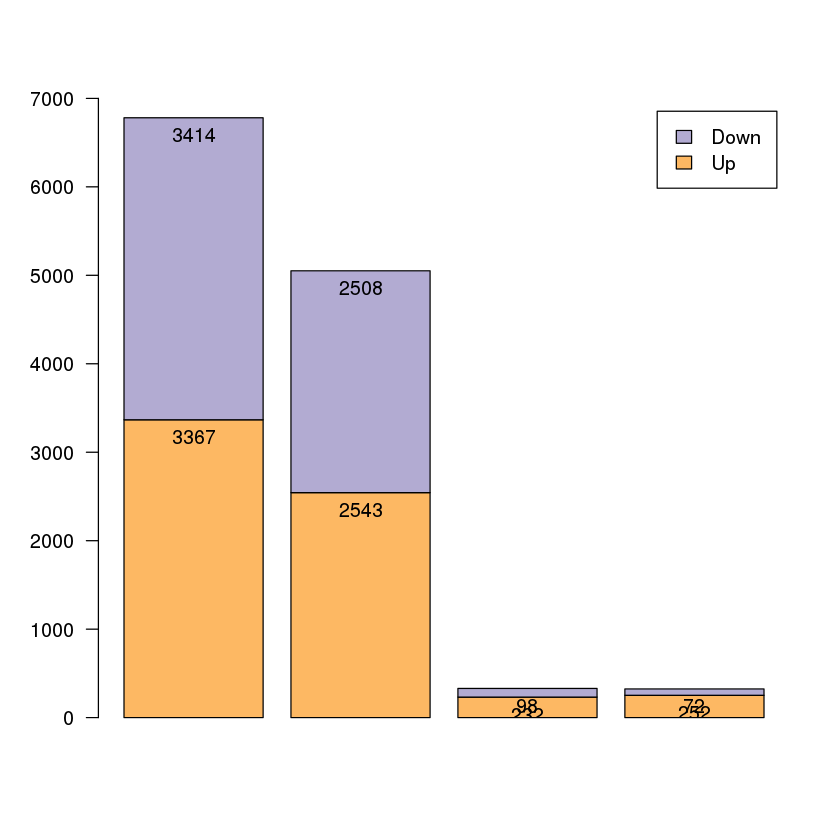

In [373]:
b = barplot(t(mm), las=2, legend.text = colnames(mm), ylim=c(0,7000), col = brewer.pal(9, "PuOr")[c(3,7)] )
text(x = b, y =mm[,1], labels = mm[,1] , pos = 1)
text(x = b, y = as.numeric(mm[,2])+ as.numeric(mm[,1]), labels = mm[,2] , pos = 1)

In [361]:
b

[1] 0.7 1.9 3.1 4.3

In [362]:
mm

Up   Down
[1,] 3367 3414
[2,] 2543 2508
[3,] 232  98  
[4,] 252  72

### Transcript- level deseq

In [12]:
gene_info = read.table("/nfs/lab/publicdata/gencode_v19/gene_info.tsv", header=T)

In [29]:
info = read.table( '/nfs/lab/projects/islet_cytok/data/RNAseq/metadata_cytok_paper.txt', sep="\t", header=T, 
                  comment.char = "")

In [31]:
expected_count = as.matrix(read.table("../pipeline/RNAseq/combined_files/cytok_transcripts.raw_counts", sep="\t", header=T, row.names=1))

In [32]:
info = droplevels(subset(info, !(sample %in% c('R310','SAMN11250012'))))
expected_count = subset(expected_count, select=as.character(info$name))


In [34]:
differential_atac(contrast = c("untr", "highcyt3"), samples = info, mat =round(expected_count), lab="transcripts")

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [36]:
res = read.table("transcripts.highcyt3.deseq_results_cytok.tsv")

In [41]:
transc_to_gene = read.table("/nfs/lab/publicdata/gencode_v19/transcript_to_gene.tsv")

In [43]:
colnames(transc_to_gene) = c("transcrip_id", "gene_id")

In [45]:
tr_info = merge(gene_info, transc_to_gene, by="gene_id")

In [47]:
res = merge(tr_info[, c('transcrip_id', 'gene_id', 'gene_name')], res, by.x=1, by.y="row.names")

In [50]:
subset(res, gene_name =="CLEC16A")

,transcrip_id,gene_id,gene_name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3623,ENST00000261657.5,ENSG00000038532.10,CLEC16A,63.0696451,0.77276994,1.9129842,0.40396044,6.862418e-01,1.000000000
31224,ENST00000381822.2,ENSG00000038532.10,CLEC16A,86.7387401,-1.86900770,0.9891993,-1.88941477,5.883627e-02,0.510189362
42936,ENST00000409552.3,ENSG00000038532.10,CLEC16A,194.7347605,0.05912350,0.1654586,0.35733097,7.208440e-01,1.000000000
43150,ENST00000409790.1,ENSG00000038532.10,CLEC16A,359.7484136,0.03267926,0.1748810,0.18686574,8.517659e-01,1.000000000
56083,ENST00000428742.2,ENSG00000038532.10,CLEC16A,0.6869818,4.27026311,4.2428036,1.00647202,3.141886e-01,1.000000000
61765,ENST00000436973.1,ENSG00000038532.10,CLEC16A,0.2049997,0.00000000,4.3280446,0.00000000,1.000000e+00,1.000000000
77580,ENST00000459723.1,ENSG00000038532.10,CLEC16A,0.8481553,-0.10454931,3.3532858,-0.03117817,9.751274e-01,1.000000000
80620,ENST00000463459.1,ENSG00000038532.10,CLEC16A,0.0000000,NA,NA,NA,NA,NA
80985,ENST00000463896.1,ENSG00000038532.10,CLEC16A,8.0007211,0.47302598,0.7089815,0.66719087,5.046502e-01,1.000000000


In [53]:
write.table (res,   "transcripts.highcyt3_deseq_results_cytok.tsv", quote=F)